In [1]:
! pip install -q kaggle

In [2]:
!pip install transformers


     |████████████████████████████████| 2.6 MB 7.8 MB/s 
     |████████████████████████████████| 3.3 MB 54.2 MB/s 
     |████████████████████████████████| 636 kB 58.6 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install unidecode
!pip install torch
!pip install tqdm

     |████████████████████████████████| 241 kB 9.7 MB/s 


In [4]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [ ]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle competitions download -c home-depot-product-search-relevance

  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 40.0MB/s]
 62% 17.0M/27.2M [00:00<00:00, 33.4MB/s]
100% 27.2M/27.2M [00:00<00:00, 46.4MB/s]
  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 74.0MB/s]
 29% 10.0M/34.8M [00:00<00:01, 13.7MB/s]
100% 34.8M/34.8M [00:00<00:00, 50.9MB/s]
100% 4.74M/4.74M [00:00<00:00, 11.5MB/s]

  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 172MB/s]


In [10]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk 
import unidecode
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [12]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
train_df= pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [13]:
desc_df = desc_df.fillna(0)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
train_df['product_uid'] = train_df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [14]:
train_df.sample(2)

,id,product_uid,product_title,search_term,relevance
17550,54132,114092,Styletto Trimming and Edging Paint Brush Set (...,3 paint bbrush,2.33
2097,6482,101115,American Craftsman 31 in. x 19 in. 70 Series S...,lasron slider windows,1.67


In [15]:
np.min(train_df['relevance'].tolist()), np.max(train_df['relevance'].tolist())

(1.0, 3.0)

In [19]:
sorted(pd.unique(train_df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [20]:
train_df['my_relevance'] = train_df['relevance'].apply(lambda x: (x - 1.0)/2.0)

In [21]:
np.min(train_df['my_relevance'].tolist()), np.max(train_df['my_relevance'].tolist())

(0.0, 1.0)

In [22]:
train_df['my_relevance2'] = train_df['my_relevance'].apply(lambda x: ((x - 0.0)/1.0) * 2.0 + 1)

In [23]:
train_df[['relevance', 'my_relevance', 'my_relevance2']].sample(4)

,relevance,my_relevance,my_relevance2
18245,2.67,0.835,2.67
10151,2.33,0.665,2.33
67964,2.67,0.835,2.67
23359,1.67,0.335,1.67


In [ ]:
train_df.describe()

,id,product_uid,relevance,my_relevance,my_relevance2
count,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634,0.690817,2.381634
std,64016.573650,30770.774864,0.533984,0.266992,0.533984
min,2.000000,100001.000000,1.000000,0.000000,1.000000
25%,57163.500000,115128.500000,2.000000,0.500000,2.000000
50%,113228.000000,137334.000000,2.330000,0.665000,2.330000
75%,168275.500000,166883.500000,3.000000,1.000000,3.000000
max,221473.000000,206650.000000,3.000000,1.000000,3.000000


In [24]:
train_df.drop_duplicates(["product_uid"]).shape[0]/len(train_df)

0.7380749861611784

In [ ]:
# pd.merge(train_df, desc_df, how='left', on='product_uid').shape[0]

74067

In [ ]:
train_df.shape[0]

74067

In [25]:
EMPTY_STRING = ''
SPACE = ' '
def clean_text(string):
  if string is None:
    return None

  string = string.strip().lower()
  string = unidecode.unidecode(string)
  string = string.replace("'", EMPTY_STRING)
  string = re.sub(r"\'n", SPACE, string)
  string = re.sub(r"\'s", " 's", string)
  string = re.sub(r"\'ve", " 've", string)
  string = re.sub(r"n\'t", " n't", string)
  string = re.sub(r"\'re", " 're", string)
  string = re.sub(r"\'d", " 'd", string)
  string = re.sub(r"\'ll", " 'll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " ( ", string)
  string = re.sub(r"\)", " ) ", string)
  string = re.sub(r"\?", r" \? ", string)
  string = re.sub(r"\s{2,}", SPACE, string)
  string = re.sub(r" +", SPACE, string)
  string = re.sub(r"/", " / ", string)
  string = re.sub(r"\|", " | ", string)
  string = re.sub(r"-", " - ", string)
  string = re.sub(r"\+", " + ", string)
  string = re.sub(r"\\\\", SPACE, string)

  return string.strip()


In [26]:
_characters_to_clean = string.punctuation + "''"
EN_STOP_WORDS = set(stopwords.words('english')) - set(['can', 'no', 'up', 'against', 'after', 'before', 'below'])

PUNCTUATIONS = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PUNCTUATIONS_PATTERN = re.compile("[{}]+$".format(re.escape(PUNCTUATIONS)))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def _is_punctuation_only(word: str):
    return PUNCTUATIONS_PATTERN.match(word)

def filter_ale_punctuation(words):
    return [word for word in words if not _is_punctuation_only(word)] if words is not None else None

def tokenize(text):
  
  processed_text = clean_text(text)
  tokens = nltk.word_tokenize(processed_text)

  
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = [word for word in tokens if word not in _characters_to_clean and word not in EN_STOP_WORDS]
  tokens = filter_ale_punctuation(tokens)
  tokens = [re.sub("\d", "#", word) for word in tokens]

  return tokens if len(tokens) > 0 else None


In [ ]:
# tokenize("he went home 123 times, before we --gabi op. -;[]")

['went', 'home', '###', 'time', 'befor', 'gabi', 'op']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [27]:
train_df['product_title_tokens'] = train_df['product_title'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:35<00:00, 2065.91it/s]


In [28]:
train_df['search_term_tokens'] = train_df['search_term'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:13<00:00, 5513.71it/s]


In [29]:

test_df['product_title_tokens'] = test_df['product_title'].progress_apply(tokenize)


100%|██████████| 166693/166693 [01:19<00:00, 2105.93it/s]


In [30]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(tokenize)

100%|██████████| 166693/166693 [00:31<00:00, 5345.07it/s]


In [31]:
pd.set_option("max_colwidth", -1)

original_train_df_length = len(train_df)
train_df = train_df[train_df['search_term_tokens'].notnull()]
len(train_df)/original_train_df_length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [32]:
train_df.sample(3)

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
7412,23170,104508,K-9 Kwik Dog Kennel 6 ft. x 6 ft. x 4 ft. Galvanized Steel Boxed Kennel Kit,6x10 chain link cage,2.33,0.665,2.33,"[k, #, kwik, dog, kennel, #, ft., x, #, ft., x, #, ft., galvan, steel, box, kennel, kit]","[#x##, chain, link, cage]"
15066,46536,111550,Philips 100W Equivalent Soft White A19 LED Light Bulb (4-Pack),PHILIPS 100W,3.00,1.000,3.00,"[philip, ###w, equival, soft, white, a##, led, light, bulb, #, pack]","[philip, ###w]"
24079,74038,121094,Whitehaus Collection Forever Hot Single-Handle Instant Hot Water Dispenser Faucet in Antique Copper,instant hot water faucet,2.33,0.665,2.33,"[whitehau, collect, forev, hot, singl, handl, instant, hot, water, dispens, faucet, antiqu, copper]","[instant, hot, water, faucet]"


In [33]:
all_words = [word for words in train_df['search_term_tokens'].tolist() for word in words]
all_words.extend([word for words in train_df['product_title_tokens'].tolist() for word in words])


In [34]:
WORD_REPLACE_MENT = '<word>'
PAD_WORD = "<pad>"

In [38]:
from collections import Counter
# sentenses = train_df['search_term_tokens'].tolist()
# sentenses.extend(train_df['product_title_tokens'].tolist())
counts = Counter(all_words)


In [39]:
MIN_WORD_COUNT = 2

In [40]:
vocab_words = set(all_words)
vocab_size_before_threshold = len(vocab_words)
vocab_words = {word for word in vocab_words if counts[word] >= MIN_WORD_COUNT}
vocab_size_before_threshold, len(vocab_words), len(all_words)

(16345, 12236, 1055648)

In [41]:
train_df['product_title_tokens'] = train_df['product_title_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 207822.55it/s]


In [42]:
train_df['search_term_tokens'] = train_df['search_term_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 436116.58it/s]


In [43]:
test_df['product_title_tokens'] = test_df['product_title_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])
test_df['search_term_tokens'] = test_df['search_term_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words] if words is not None else [])

100%|██████████| 166693/166693 [00:00<00:00, 261520.67it/s]


In [44]:
train_df[train_df['product_title_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens


In [45]:
train_df[train_df['search_term_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens


In [46]:
vocab = {word: index + 2 for (index, word) in enumerate(vocab_words)}
vocab[PAD_WORD] = 0 
vocab[WORD_REPLACE_MENT] = 1
PAD_WORD_ID = vocab[PAD_WORD]

In [47]:
token_id_to_word = {id: word for (word, id) in vocab.items()}
len(token_id_to_word), len(vocab)

(12238, 12238)

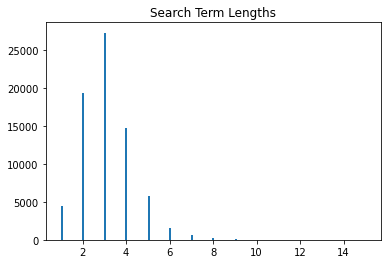

In [48]:
import matplotlib.pyplot as plt

search_term_lengths = train_df['search_term_tokens'].map(len).tolist()
_ = plt.hist(search_term_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Search Term Lengths")
plt.show()

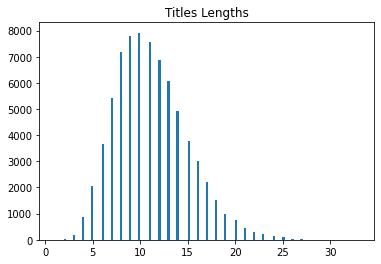

In [49]:
import matplotlib.pyplot as plt

title_lengths = train_df['product_title_tokens'].map(len).tolist()
_ = plt.hist(title_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Titles Lengths")
plt.show()

In [50]:
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [55]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df, vocab):
        self._df = df
        self._vocab = vocab

    def __len__(self):
        return len(self._df)

    def _fix_words(self, words_ids, required_size):
        if len(words_ids) > required_size:
            # ids = np.random.choice(len(words_ids), required_size)
            words_ids = words_ids[0: required_size]
        elif len(words_ids) < required_size:
            b = np.zeros(required_size - len(words_ids), dtype=int)
            words_ids = np.concatenate((words_ids, b), axis=None)

        return words_ids

    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array([self._vocab[w] for w in row['search_term_tokens']])
        search_term_length = min(len(search_term), MAX_SEARCH_TERM_LENGTH)
        search_term = self._fix_words(search_term, MAX_SEARCH_TERM_LENGTH)


        product_title = np.array([self._vocab[w] for w in row['product_title_tokens']])
        product_title_length = min(len(product_title), MAX_TITLE_LENGTH)
        product_title = self._fix_words(product_title, MAX_TITLE_LENGTH)

   

        return row['id'], search_term, search_term_length, product_title, product_title_length, row['my_relevance']
    


,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
41226,125601,143225,Bosch Fast Spiral Masonry Set (14-Piece),concrete drill bits,2.67,0.835,2.67,"[bosch, fast, spiral, masonri, set, ##, piec]","[concret, drill, bit]"


In [151]:
BATCH_SIZE = 64
data_loader = DatasetLoader(train_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance']], vocab)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)

test_df['my_relevance'] = -1

test_loader = DatasetLoader(test_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance']], vocab)

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader)

74047

In [57]:
for ids, search_term, search_term_length, product_title, product_title_length, relevance_score in train_data_loader:
  break

In [61]:
[token_id_to_word[x] for x in product_title[4].numpy().tolist()]


['ge',
 'profil',
 'advantium',
 '##',
 'electr',
 'wall',
 'oven',
 'speed',
 'cook',
 'convect',
 'stainless',
 'steel',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
product_title_length[1]

tensor(11)

In [62]:
train_df[train_df['id'] == ids[4].numpy().item()]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
41975,127829,144360,GE Profile Advantium 30 in. Electric Wall Oven with Speed Cook and Convection in Stainless Steel,built in oven microwave 30 in,2.33,0.665,2.33,"[ge, profil, advantium, ##, electr, wall, oven, speed, cook, convect, stainless, steel]","[built, oven, microwav, ##]"


In [63]:
search_term.shape, search_term_length.shape , product_title.shape , product_title_length.shape  

(torch.Size([5, 5]), torch.Size([5]), torch.Size([5, 15]), torch.Size([5]))

In [152]:
class EncoderModel(nn.Module):

    def __init__(self, n_vocab):
        super(EncoderModel, self).__init__()
        self.lstm_size = 100
        self.embedding_dim = 300
        

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        self.rnn = nn.LSTM(self.embedding_dim, 300, 1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(600, 300)
        self.fc2 = nn.Linear(300, 100)

    def forward(self, x, lengths):

        embed = self.embedding(x)
            
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        
        packed_output, hn = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]
        out_reverse = output[:, 0, self.embedding_dim :]
        out = torch.cat((out_forward, out_reverse), 1)
        
        #out = torch.tanh(out_reduced)
        out = self.fc1(out)
        out = torch.tanh(out)
        out = self.fc2(out)

        return out
    
    def reset_parameters(self):
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        

class RelevanceModel(nn.Module):

  def __init__(self, n_vocab):
    super(RelevanceModel, self).__init__()
    self.query_encoder = EncoderModel(n_vocab)#.to(device)
    self.title_encoder = EncoderModel(n_vocab)#.to(device)
    self.fc = nn.Linear(200, 1)
    self._ol = nn.LogSoftmax(dim=1)

  def  forward(self, queries, titles, queries_lengths, titles_lengths):
    encoded_queries = self.query_encoder(queries, queries_lengths)
    title_encoded = self.title_encoder(titles, titles_lengths)

    out = torch.cat((encoded_queries, title_encoded), 1)
    #out = torch.tanh(out)

  
    out = self.fc(out)
    
    # out = self._ol(out)
    return out 

    #return torch.sigmoid(out)

  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)
    self.query_encoder.reset_parameters()
    self.title_encoder.reset_parameters()
    

# class RelevanceModel(nn.Module):

#   def __init__(self, n_vocab):
#     super(RelevanceModel, self).__init__()
#     self.encoder = EncoderModel(n_vocab)#.to(device)
#     #self.title_encoder = EncoderModel(n_vocab)#.to(device)
#     self.fc = nn.Linear(200, 1)

#   def  forward(self, queries, titles, queries_lengths, titles_lengths):
#     encoded_queries = self.encoder(queries, queries_lengths)
#     encoded_queries = self.encoder(titles, titles_lengths)

#     out = torch.cat((query_encoded, title_encoded), 1).to(device)
#     out = torch.tanh(out)

  
#     out = self.fc(out)

#     return torch.sigmoid(out)

#   def reset_parameters(self):
#     nn.init.uniform_(self.fc.weight)
#     self.encoder.reset_parameters()
    


In [110]:

# for x in model.parameters():
#   if not x.is_cuda:
#     print(x) 

# e1 = EncoderModel(len(vocab)).to(device)
# r = e1(product_title.to(device), product_title_length)
output.shape, product_title_length
#output = r 

#8
#out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]

# output[range(len(output)), product_title_length - 1, :300][0]
product_title_length
#output[0][14], product_title_length

tensor([14, 12, 10, 15,  8])

In [118]:
output[0][13][300:]
output[:, 0, 300 :].shape, output[:, 0,]


(torch.Size([5, 300]), torch.Size([5, 15, 600]))

In [66]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def categorical_cross_entropy(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

In [153]:
model = RelevanceModel(len(vocab))
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(
        model.parameters(), lr=0.0001)

mse_loss  = nn.MSELoss()


# model(search_term, product_title, search_term_length,  product_title_length)

In [70]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [132]:
# loss.backward
scores.shape, target_relevance_score.shape, search_term.shape

(torch.Size([5, 19, 1]), torch.Size([5]), torch.Size([5, 5]))

In [ ]:

model.train()

for epoc in range(1000):

  running_loss = 0.0
  counter = 0.0

  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).float().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title, search_term_length,  product_title_length)
    loss = mse_loss(scores.view(-1, 1), target_relevance_score.view(-1, 1))

    

    loss.backward()
    optimizer.step()

    #nn.utils.clip_grad_norm(model.parameters(), 0.5)
    
    running_loss += loss.item()
    counter = search_term.shape[0]
  #   break
  
  # break
  
  print('epoc {} loss {} counter {}'.format(epoc, running_loss/counter, counter))




In [76]:
# mse_loss(scores.view(1, -1), target_relevance_score.view(1, -1))
counter

0.0

In [147]:


model.eval()
test_scores = []
test_ids =[]
tt = []
for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
  search_term = Variable(search_term).to(device)
  product_title = Variable(product_title).to(device)
  

  scores = model(search_term, product_title, search_term_length,  product_title_length)

  test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
  test_ids.extend(ids.numpy().tolist())
  tt.extend(target_relevance_score.numpy().tolist())

  break
  



In [ ]:
scores.flatten().shape, target_relevance_score.shape

(torch.Size([32]), torch.Size([32]))

In [148]:
scores

tensor([[ 0.0211],
        [-2.7342],
        [-2.6735],
        [-2.3742],
        [ 4.8473]], device='cuda:0', grad_fn=<AddmmBackward>)